In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
from mlxtend.data import loadlocal_mnist
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt
from numpy.random import randint

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras 
from keras.utils.np_utils import to_categorical   

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Conv2DTranspose, Reshape, Embedding, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

#####Przygotowanie danych

In [10]:
X_train, y_train = loadlocal_mnist(
            images_path='/content/gdrive/My Drive/Colab Notebooks/train-images.idx3-ubyte', 
            labels_path='/content/gdrive/My Drive/Colab Notebooks/train-labels.idx1-ubyte')
X_test, y_test = loadlocal_mnist(
            images_path='/content/gdrive/My Drive/Colab Notebooks/t10k-images.idx3-ubyte', 
            labels_path='/content/gdrive/My Drive/Colab Notebooks/t10k-labels.idx1-ubyte')

In [11]:
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
print(y_train_bin)
y_test_bin = lb.fit_transform(y_test)

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [12]:
X_train.astype('float32')
X_test.astype('float32')

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train).reshape(X_train.shape[0], 28, 28,1)
X_test_norm = mms.transform(X_test).reshape(X_test.shape[0], 28, 28,1)

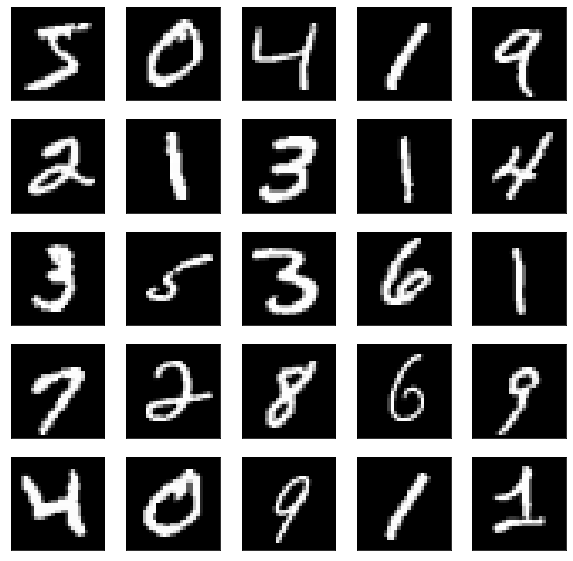

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_norm[i].reshape(28,28), cmap='gray')
plt.show()

#####Przygotowanie modelu sieci

In [14]:
opt = keras.optimizers.Adam(lr=0.0002)
from keras.optimizers import RMSprop
#opt = RMSprop(lr=0.0002, decay=6e-8)
n_classes = 10
image_dim = X_train_norm[0].shape

#discriminator = tf.keras.Sequential(name='D')
d_in_label = Input(shape=(1,))
d_l2 = Embedding(n_classes, 10)(d_in_label) #mapuje klasę na 10-elementowy wektor
d_l3 = Dense(image_dim[0]*image_dim[1])(d_l2)
d_l4 = Reshape((image_dim[0], image_dim[1], 1))(d_l3)
d_in_image = Input(shape=image_dim)
d_merge = Concatenate()(([d_in_image, d_l4]))
d_ml1 = Conv2D(32, (3,3), input_shape=(28,28,1))(d_merge)
d_ml1 = Activation('relu')(d_ml1)
d_ml1 = MaxPooling2D((2,2))(d_ml1)
d_ml2 = Flatten()(d_ml1)
d_ml3 = Dense(10, activation='relu')(d_ml2)
d_out_layer = Dense(1, activation = 'sigmoid')(d_ml3)
discriminator = Model([d_in_image, d_in_label], d_out_layer, name="Discriminator")
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

#generator = tf.keras.Sequential(name='G')
g_in_label = Input(shape=(1,))
g_l2 = Embedding(n_classes, 10)(g_in_label) #mapuje klasę na 10-elementowy wektor
g_l3 = Dense(24*24)(g_l2)
g_l4 = Reshape((24, 24, 1))(g_l3)
g_in_noise = Input(shape=(14,))
g_nl2 = Dense(32)(g_in_noise)
g_nl3 = Dense(576, activation='relu')(g_nl2)
g_nl4 = Reshape((24,24,1))(g_nl3)
g_merge = Concatenate()(([g_nl4, g_l4]))
g_ml1 = Conv2DTranspose(64, 3, activation='relu')(g_merge)
g_out_layer = Conv2DTranspose(1, 3, activation='relu')(g_ml1)
generator = Model([g_in_noise, g_in_label], g_out_layer, name="Generator")
generator.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
generator.summary()

#GAN = tf.keras.Sequential(name='GAN')
# GAN.add(generator)
# GAN.add(discriminator)
g_noise, g_label = generator.input
g_output = generator.output
gan_output = discriminator([g_output, g_label])
GAN = Model([g_noise, g_label], gan_output)
GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/checkpointGAN{epoch:02d}-{accuracy:.2f}.hdf5'

keras_callbacks   = [
      EarlyStopping(monitor='loss', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        100         input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       8624        embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

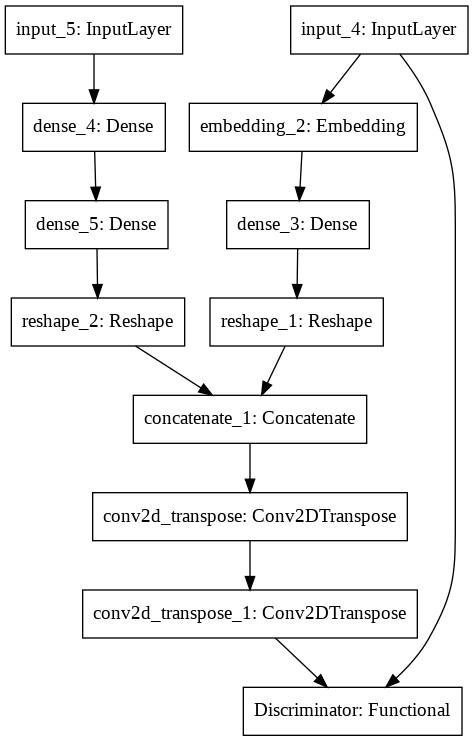

In [15]:

# # wizualizacja modelu

from keras.utils import plot_model
plot_model(GAN, to_file='model.png')

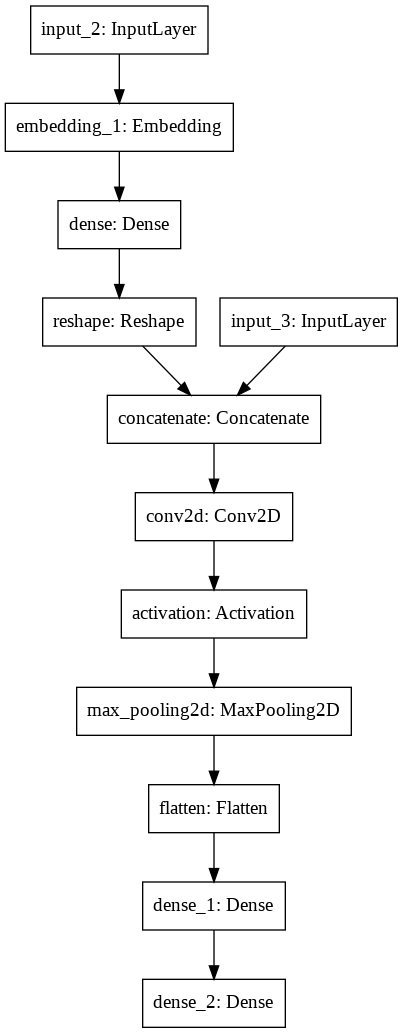

In [18]:
plot_model(discriminator, to_file='/content/gdrive/My Drive/Colab Notebooks/discriminator.png')

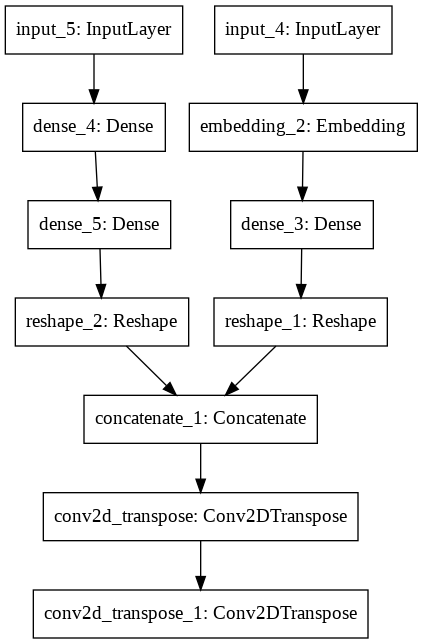

In [17]:
plot_model(generator, to_file='generator.png')

In [ ]:
X_fake_train = np.zeros((X_train_norm.shape[0], 14))
for sample in range(len(X_fake_train)):
  X_fake_train[sample] = np.random.normal(loc=0.5, scale=0.25, size=(14,))

y_fake = randint(0, n_classes, X_fake_train.shape[0])

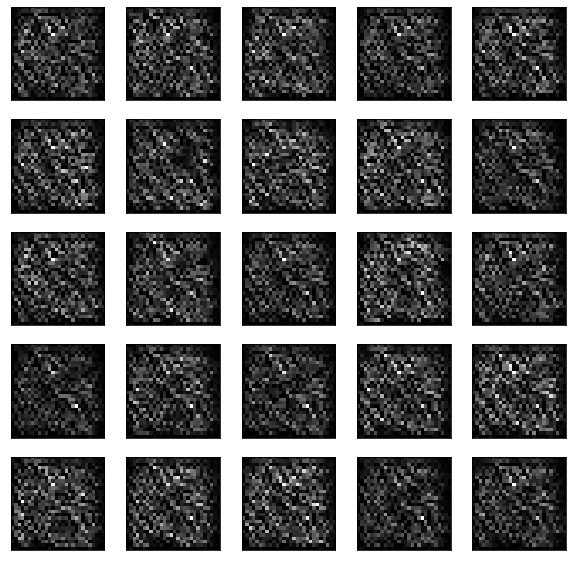

In [ ]:
X_fake_generated_0 = generator.predict([X_fake_train, y_fake])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_fake_generated_0[i].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
epochs = 30 
component_epochs = 10 
X_fake = X_fake_generated_0
y_fake = y_fake
images_history = []

for epoch in range(epochs):

  print("\nEpoch: ", epoch+1, "\n")
  # X_true_and_fake = np.concatenate(([X_train_norm, y_train], [X_fake.reshape(X_fake.shape[0],28,28,1), y_fake]))
  # y_true_and_fake = np.zeros(X_true_and_fake.shape[0])
  # y_true_and_fake[:X_train_norm.shape[0]] = 1
  
  print("\nDiscriminator training:\n")
  D_hist = discriminator.fit([X_train_norm, y_train], np.ones(X_train_norm.shape[0]), epochs=component_epochs)
  D_hist = discriminator.fit([X_fake.reshape(X_fake.shape[0],28,28,1), y_fake], np.zeros(X_fake.shape[0]), epochs=component_epochs)
  for layer in discriminator.layers:
    layer.trainable = False
  
  noise = np.zeros((X_train_norm.shape[0], 14))
  for sample in range(len(noise)):
    noise[sample] = np.random.normal(loc=0.5, scale=0.25, size=(14,))
  y_fake = randint(0, n_classes, noise.shape[0])  
  y_noise = np.ones(noise.shape[0])

  print("\nGenerator training:\n")
  GAN.fit([noise, y_fake], y_noise, epochs=component_epochs)

  X_fake = generator.predict([X_fake_train, y_fake])
  images_history.append([X_fake[0:5], y_fake[0:5]])
  for layer in discriminator.layers:
    layer.trainable = True


Epoch:  1 


Discriminator training:

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0260 - accuracy: 0.9996
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 3.4559e-06 - accuracy: 1.0000
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.1319e-07 - accuracy: 1.0000
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 2.1711e-07 - accuracy: 1.0000
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 7.5361e-08 - accuracy: 1.0000
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 2.7378e-08 - accuracy: 1.0000
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1455e-08 - accuracy: 1.0000
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 5.3409e-09 - accuracy: 1.0000
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 3.2623e-09 - accuracy: 1.0000
Epoch 10/10

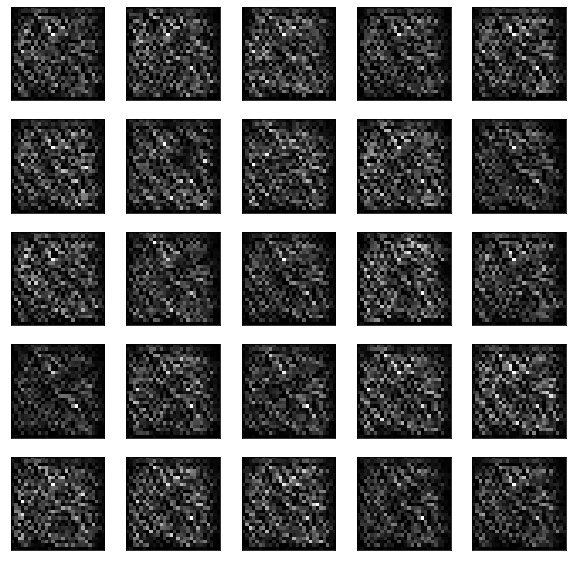

In [ ]:
X_fake = generator.predict([X_fake_train, y_fake])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_fake[i].reshape(28,28), cmap='gray')
plt.show()

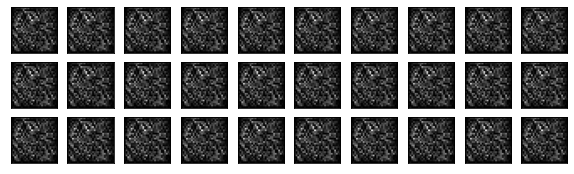

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_history[i][0][0].reshape(28,28), cmap='gray')
plt.show()